# Instrumental Variables

Instrumental variables (IV) refer to a method used in econometrics to estimate causal relationships when controlled experiments are not feasible and an explanatory variable is correlated with the error term, leading to **endogeneity issues** {cite}`angrist1996identification`. Saying that a variable is correlated with the error term means that the variable and the error term share some common influence or that the variable captures some part of the variability in the dependent variable that should be attributed to the error term. When we say a variable is correlated with the error term, it means that both the variable and the error term are influenced by some common external factors. In other words, the variable captures some variability in the outcome that should be attributed to these external influences, which introduces bias in our estimates. This happens because the variable not only shows its direct effect on the outcome but also the effect of those omitted external factors.

## Endogeneity
Endogeneity can occur due to:
1. **Omitted variable bias**: unobserved variables that affect both the explanatory variable and the outcome.
2. **Simultaneity**: when the explanatory variable and the outcome influence each other
3. **Measurement error**: Inaccuracies in measuring the explanatory variable.

For instance, consider trying to understand how wind power production impacts wholesale electricity prices. However, if wind power production and prices are also affected by factors like solar power or broader economic trends, these external influences can bias our estimates. Here, we can use an IV, like wind speed forecasts, which affects wind power production but doesn’t directly influence electricity prices except through its effect on wind power. This helps us isolate the true effect of wind power production on prices, giving a clearer picture of the causal relationship.

An IV has two main properties:
1. **Relevance**: the IV needs to be something that is related to the variable you're interested in studying.
2. **Exogeneity**: the IV should not be influenced by other factors that affect the outcome you're studying.


Here is a representation of a case where a candidate IV (wind speed forecast) can help us isolate the effect of an explanatory variable (wind power production), on the response variable (price).

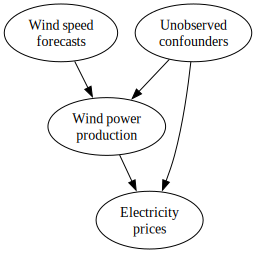

In [1]:
import graphviz
from IPython.display import display

# Create a new graph
dot = graphviz.Digraph()

# Add nodes
dot.node('Z', 'Wind speed\nforecasts')
dot.node('X', 'Wind power\nproduction')
dot.node('Y', 'Electricity \nprices')
dot.node('U', 'Unobserved\nconfounders')

# Add edges
dot.edge('Z', 'X')
dot.edge('X', 'Y')
dot.edge('U', 'X')
dot.edge('U', 'Y')

# Display the graph in the notebook
display(dot)

## Two-Stage Least Squares (2SLS)

Two-stage least squares (2SLS) is an econometric approach used to address endogeneity using IVs {cite}`angrist1995two`. It is performed in two steps:
1. Regress the endogenous explanatory variable on the IV to obtain predicted values.
2. Regress the dependent variable on the predicted values obtained from the first stage.

The key idea is that if we use the IV (wind speed forecast) to predict the endogenous explanatory variable (wind power production), and then use these predicted values to estimate its effect on the response variable (price), we essentially use only the part of the variation in the explanatori variable that is “clean” of the confounding effects of the unobserved confounders (e.g., solar generation, macroeconomic trends). This allows us to estimate a causal effect that is not biased.

If we want to visualize this effect, this corresponds to removing the edge from the unobserved confounders to the endogenous explaantory variable.

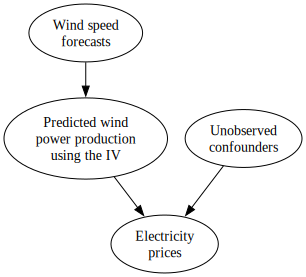

In [2]:
# Create a new graph
dot = graphviz.Digraph()

# Add nodes
dot.node('Z', 'Wind speed\nforecasts')
dot.node('X', 'Predicted wind \npower production \nusing the IV')
dot.node('Y', 'Electricity \nprices')
dot.node('U', 'Unobserved\nconfounders')

# Add edges
dot.edge('Z', 'X')
dot.edge('X', 'Y')
dot.edge('U', 'Y')

# Display the graph in the notebook
display(dot)

## Example

Let's now generate some data to show how this works in practice. Since the confounders are, by definition, **unobserved**, we assume to only have at our disposal the wind speed forecast, the wind power production, and the electricity prices.

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulate data
n = 1000
true_effect = 2  # True causal effect of wind power production on electricity prices
wind_speed_forecasts = np.random.uniform(0, 10, n)  # IV
unobserved_confounders = np.random.normal(0, np.sqrt(10), n)  # Unobserved factors with variance 10
wind_power_production = 2 * wind_speed_forecasts + unobserved_confounders + np.random.normal(0, 1, n)
electricity_prices = true_effect * wind_power_production + 1.5 * unobserved_confounders + np.random.normal(0, 1, n)

# Create DataFrame
data = pd.DataFrame({
    'WindSpeedForecasts': wind_speed_forecasts,
    'WindPowerProduction': wind_power_production,
    'ElectricityPrices': electricity_prices
})

data.head()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,WindSpeedForecasts,WindPowerProduction,ElectricityPrices
0,3.745401,6.646425,15.010277
1,9.507143,14.708451,22.433042
2,7.319939,14.337450,29.275135
3,5.986585,14.664067,31.182353
4,1.560186,4.973025,12.114167


### Ignoring Confounders

If we simply ignore the problem of having unobserved confounders, we might be tempted to simply fit a model on the available data. Let's try that.

In [4]:
# Perform OLS regression
X_ols = sm.add_constant(data['WindPowerProduction'])
ols_model = sm.OLS(data['ElectricityPrices'], X_ols).fit()
print("OLS Regression Results:")
print(ols_model.summary())

OLS Regression Results:Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

                            OLS Regression Results                            
Dep. Variable:      ElectricityPrices   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 1.225e+04
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        09:55:40   Log-Likelihood:                -2886.7
No. Observations:                1000   AIC:                             5777.
Df Residuals:                     998   BIC:                             5787.
Df Model:                           1                                         
Covariance Type

### 2SLS

Now, we use the 2SLS approach and fit two models, the first one to predit the explanatory variable and the second one using the predicted variable to predict the response.

In [5]:
# First stage of 2SLS: Regress WindPowerProduction on WindSpeedForecasts
X_first_stage = sm.add_constant(data['WindSpeedForecasts'])
first_stage_model = sm.OLS(data['WindPowerProduction'], X_first_stage).fit()
data['FittedWindPowerProduction'] = first_stage_model.fittedvalues

# Second stage of 2SLS: Regress ElectricityPrices on the fitted values from the first stage
X_second_stage = sm.add_constant(data['FittedWindPowerProduction'])
second_stage_model = sm.OLS(data['ElectricityPrices'], X_second_stage).fit()
print("\n2SLS Regression Results:")
print(second_stage_model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

2SLS Regression Results:
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:      ElectricityPrices   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     1034.
Date:                Mon, 23 Dec 2024   Prob (F-statistic):          3.21e-156
Time:                        09:55:40   Log-Likelihood:                -3824.2


### Comparing Estimation Results

Let's now **compare the results** obtained with the naive approach, ignoring the presence of confounders, and the 2SLS modelling.

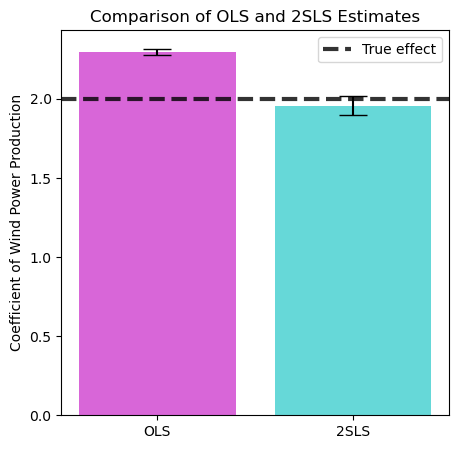

In [6]:
# Extract coefficients and standard errors
ols_coef = ols_model.params.iloc[1]
ols_se = ols_model.bse.iloc[1]
second_stage_coef = second_stage_model.params.iloc[1]
second_stage_se = second_stage_model.bse.iloc[1]

# Plot the comparison
labels = ['OLS', '2SLS']
coefficients = [ols_coef, second_stage_coef]
errors = [ols_se, second_stage_se]

plt.figure(figsize=(5, 5), dpi=100)
plt.bar(labels, coefficients, yerr=errors, capsize=10, color=['m', 'c'], alpha=0.6)
plt.axhline(y=true_effect, color='k', linestyle='--', lw=3, alpha=0.8,  label='True effect')
plt.ylabel('Coefficient of Wind Power Production')
plt.title('Comparison of OLS and 2SLS Estimates')
plt.legend()
plt.show()

We can now see tha simply using a model on all the observed variables leads us to a **biased estimate**. Instead, using 2SLS we can get much closer to the real effect.